## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [87]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [35]:
daily_data = data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum'
})
display(daily_data)

user_id  purchase
date       group                   
2021-01-02 A         2894       362
           B         2889       348
2021-01-03 A         6684       760
           B         6710       762
2021-01-04 A         6655       810
           B         6629       773
2021-01-05 A         6538       801
           B         6586       758
2021-01-06 A         6684       778
           B         6844       848
2021-01-07 A         6678       805
           B         6703       776
2021-01-08 A         6769       805
           B         6795       821
2021-01-09 A         6725       806
           B         6714       794
2021-01-10 A         6745       763
           B         6778       858
2021-01-11 A         6787       808
           B         6766       785
2021-01-12 A         6615       809
           B         6707       820
2021-01-13 A         6649       779
           B         6589       734
2021-01-14 A         6635       842
           B         6694       799
2021-01-15 A         6809       823
           B         6640       757
2021-01-16 A         6683       816
           B         6644       795
2021-01-17 A         6691       818
           B         6631       844
2021-01-18 A         6578       820
           B         6707       835
2021-01-19 A         6665       795
           B         6628       780
2021-01-20 A         6626       763
           B         6767       797
2021-01-21 A         6823       859
           B         6652       772
2021-01-22 A         6675       796
           B         6748       795
2021-01-23 A         6783       854
           B         6728       814
2021-01-24 A         3811       451
           B         3727       449

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [37]:
sum_data = data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
})
sum_data['price'] = sum_data['price']/1000000
display(sum_data)

,user_id,purchase,price
group,,,
A,147202,17723,1436.26
B,147276,17514,1554.10


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [61]:
data_set_a = data[data['group']=='A']
data_set_b = data[data['group']=='B']
data_set_a = set(data_set_a['user_id'])
data_set_b = set(data_set_b['user_id'])
data_id_intesection = data_set_a.intersection(data_set_b)
display(len(data_id_intesection))

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [88]:
updated_data = data[data['user_id'].apply(lambda x: x not in data_id_intesection)]

Где user_intersection - множество пересечений пользователей групп А и B.

In [63]:
updated_data

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

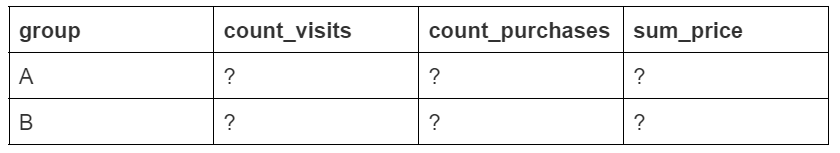
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [91]:
grouped_data = updated_data.groupby('group').agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id':'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})

In [92]:
grouped_data

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

In [72]:
discrepancy = round((145381-145307)/145381*100, 2)
display(discrepancy)

0.05

*Исходя из данных в таблице grouped_data, можно сделать вывод, что количество посещений (количество пользователей) в группах А и B, соответствено, отличаются на незначительную величину 0.05%.<br> Считаю, что количество посещений обоих вариантов сопоставимо, и можно считать выборки сбалансированными.*

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [93]:
grouped_data['conversion'] = round((grouped_data['count_purchases']/grouped_data['count_visits'])*100, 2)
grouped_data['mean_check'] = round((grouped_data['sum_price']/grouped_data['count_purchases']))
display(grouped_data)

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

*Вариант А незначительно эффективнее варианта B по показателю конверсии, а вариант В эффективнее варианта А по среднему чеку*

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [102]:
updated_data_df = updated_data.groupby(['group', 'price'])['purchase'].count().unstack()
updated_data_df

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,127820,5182,5271,1832,3478,1724
B,128091,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

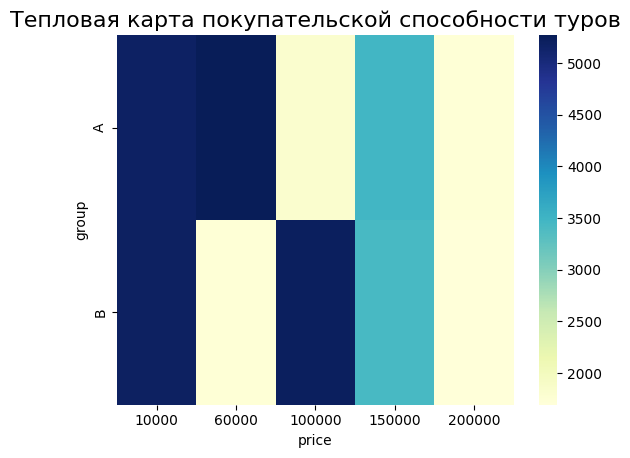

In [107]:
updated_data_df = updated_data_df.drop([0], axis=1)
heatmap = sns.heatmap(data=updated_data_df, cmap='YlGnBu')
heatmap.set_title('Тепловая карта покупательской способности туров', fontsize=16);

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

*Тепловая карта покупательской способности туров показывает, что покупательнвая способность участников группы В незначительно выше, чем участников группы А, т.к. участники группы В приобрели значительно больше более дорогих туров в Таиланд, чем участники группы А. При этом участники группы В приобрели большее количество более дешевых туров в Турцию, чем участники группы В*

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [110]:
daily_data = updated_data.groupby(['date','group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'users_count', 'purchase':'purchase_count', 'price':'price_sum'})
daily_data['conversion'] = round((daily_data['purchase_count']/daily_data['users_count'])*100, 2)
daily_data['mean_check'] = round((daily_data['price_sum']/daily_data['purchase_count']))
display(daily_data.head())

,date,group,users_count,purchase_count,price_sum,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [130]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_purchase'] = daily_data.groupby(['group'])['purchase_count'].cumsum()
# вычисляем кумулятивную сумму покупок
daily_data['cum_price'] = daily_data.groupby(['group'])['price_sum'].cumsum()
daily_data['cum_conversion'] = daily_data['cum_purchase']/daily_data['cum_users_count'] * 100
daily_data['cum_mean_check'] = daily_data['cum_price']/daily_data['cum_purchase']
mask1 = daily_data['date'] == '2021-01-20'
mask2 = daily_data['group'] == 'B'
mask3 = daily_data['date'] == '2021-01-12'
mask4 = daily_data['group'] == 'A'
display(round(daily_data[mask1&mask2]['cum_conversion'], 2))
display(round(daily_data[mask3&mask4]['cum_mean_check']))

37    11.9
Name: cum_conversion, dtype: float64

20    81492.0
Name: cum_mean_check, dtype: float64

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

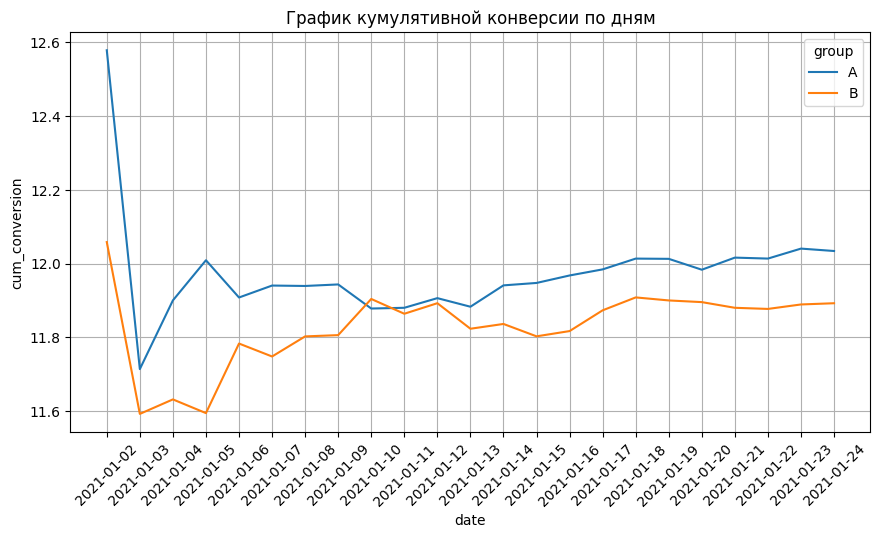

In [131]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

*До 2021-01-08 конверсия была нестабильна, но после 2011-01-12 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени.<br>
Также хотел бы обратить внимание на различие в конверсии в первые дни теста: тут наглядно отображена проблема подглядывания, когда статистическая значимость ошибочно могла быть достигнута уже в самом начале теста.<br>
На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.*

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [133]:
converted_piv= updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv.head())

,sum,count
group,,
A,17487,145307
B,17290,145381


In [134]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

*Z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то полученная разница в метрике в группах статистически не значима. Т.е разницы между вариантами посадочной страницы сайта нет — они одинаково эффективны по метрике конверсии!*

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [137]:
#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

# Функция для определения доверительного интервала для конверсии в группах:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

# Строим доверительный интервал для конверсии в группах через объявления функции proportions_conf_interval:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [138]:
# Функция для определения доверительного интервала для разницы конверсии в группах:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

*Можно сделать вывод, что с надёжностью в 95 % конверсия группы А лежит в интервале от 11.87 % до 12.2 %, а конверсия группы B лежит в интервале от 11.73 % до 12.06 %.<br>
Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38 % до 0.09 %. То есть разница в конверсии может быть как положительной, так и отрицательной. Мы имеем дело с третьим случаем — интервал охватывает точку 0.<br>Т.е статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике*.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [159]:
#фильтруем данные группы А
mask_a = daily_data['group'] == 'A'
a_daily_data = daily_data[mask_a]['mean_check']
#фильтруем данные группы B
mask_b = daily_data['group'] == 'B'
b_daily_data = daily_data[mask_b]['mean_check']

from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(a_daily_data)
shapiro_result_b = shapiro(b_daily_data)
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [155]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = ' Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data[mask_a]['mean_check'],
    b=daily_data[mask_b]['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу.  Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

*Параметрический T-тест показал, что с надёжностью в 95 %  ежедневный средний чек в группе А меньше чем в группе B*

In [162]:
daily_data[mask_a]['mean_check'].std()

3096.388506406891

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [164]:
from scipy.stats import t

n = daily_data[mask_a]['mean_check'].shape[0] # размер выборки
k = n - 1 # число степеней свободы
x_mean_a = daily_data[mask_a]['mean_check'].mean() # выборочное среднее группы А
x_mean_b = daily_data[mask_b]['mean_check'].mean() # выборочное среднее группы B
x_std_a = daily_data[mask_a]['mean_check'].std() # выборочное стандартное отклонение группы А
x_std_b = daily_data[mask_b]['mean_check'].std() # выборочное стандартное отклонение группы B
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std_a/(n ** 0.5) # погрешность
lower_bound = x_mean_a - eps # левая (нижняя) граница
upper_bound = x_mean_a + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал группы A: {}'.format(confidence_interval)) # выводим результат для группы А

t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std_b/(n ** 0.5) # погрешность
lower_bound = x_mean_b - eps # левая (нижняя) граница
upper_bound = x_mean_b + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервал
print('Доверительный интервал группы B: {}'.format(confidence_interval)) # выводим результат для группы B

Доверительный интервал группы A: (79630, 82308)
Доверительный интервал группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

*Можно сделать вывод, что с надёжностью в 95 % доверительный интервал для среднего чека группы А лежит в интервале от 79630 до 82308 , а доверительный интервал для среднего чека группы B лежит в интервале от 87626 до 89526*.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

*Согласно проведенному исследованию, истинные значения конверсий в группах равны (с уровнем значимости 0.05), т.е полученная разница в метрике в группах статистически не значима.<br>
Тест на доверительный интервал для разности конверсий в группах также показал статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.<br>
Что касается исследования по ежедневному среднему чеку, то параметрический T-тест показал, что с надёжностью в 95 % ежедневный средний чек в группе А меньше чем в группе B, а доверительный интервал для среднего чека группы B больше, чем группы А.<br>
По метрике среднего чека вариант В дизайна посадочной страницы является более эффективным, чем вариант А, таким образом вариант дизайна В более предпочтительный.*